In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## alexnet

In [3]:
dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
model = torchvision.models.alexnet(pretrained=True).cuda()

In [3]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(model, dummy_input, "alexnet.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10, 3, 224, 224),
      %learned_0 : Float(64, 3, 11, 11),
      %learned_1 : Float(64),
      %learned_2 : Float(192, 64, 5, 5),
      %learned_3 : Float(192),
      %learned_4 : Float(384, 192, 3, 3),
      %learned_5 : Float(384),
      %learned_6 : Float(256, 384, 3, 3),
      %learned_7 : Float(256),
      %learned_8 : Float(256, 256, 3, 3),
      %learned_9 : Float(256),
      %learned_10 : Float(4096, 9216),
      %learned_11 : Float(4096),
      %learned_12 : Float(4096, 4096),
      %learned_13 : Float(4096),
      %learned_14 : Float(1000, 4096),
      %learned_15 : Float(1000)):
  %17 : Float(10, 64, 55, 55) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[11, 11], pads=[2, 2, 2, 2], strides=[4, 4]](%actual_input_1, %learned_0, %learned_1), scope: AlexNet/Sequential[features]/Conv2d[0] # /home/brian/tools/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %18 : Float(10, 64, 55, 55) = onnx::Relu(%17), scope:

In [3]:
import onnx

# Load the ONNX model
model = onnx.load("alexnet.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))


graph torch-jit-export (
  %actual_input_1[FLOAT, 10x3x224x224]
) initializers (
  %learned_0[FLOAT, 64x3x11x11]
  %learned_1[FLOAT, 64]
  %learned_10[FLOAT, 4096x9216]
  %learned_11[FLOAT, 4096]
  %learned_12[FLOAT, 4096x4096]
  %learned_13[FLOAT, 4096]
  %learned_14[FLOAT, 1000x4096]
  %learned_15[FLOAT, 1000]
  %learned_2[FLOAT, 192x64x5x5]
  %learned_3[FLOAT, 192]
  %learned_4[FLOAT, 384x192x3x3]
  %learned_5[FLOAT, 384]
  %learned_6[FLOAT, 256x384x3x3]
  %learned_7[FLOAT, 256]
  %learned_8[FLOAT, 256x256x3x3]
  %learned_9[FLOAT, 256]
) {
  %17 = Conv[dilations = [1, 1], group = 1, kernel_shape = [11, 11], pads = [2, 2, 2, 2], strides = [4, 4]](%actual_input_1, %learned_0, %learned_1)
  %18 = Relu(%17)
  %19 = MaxPool[kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [2, 2]](%18)
  %20 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%19, %learned_2, %learned_3)
  %21 = Relu(%20)
  %22 = MaxPool[kernel_shape = [3, 3], pads = [0

## mnist

In [16]:
root = '~/data/DS'

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [26]:
trainset = torchvision.datasets.MNIST(root, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4)

testset = torchvision.datasets.MNIST(root, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4)

In [20]:
subsample = torch.utils.data.Subset(trainset, range(0, len(trainset), 2))
subset_train = torch.utils.data.DataLoader(subsample, batch_size=64, shuffle=True)

In [110]:
class Net(nn.Module):

    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=5),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Linear(1600, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:0
print(device)
losses = []
net = Net()
net.to(device)

cuda:0


Net(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=1600, out_features=10, bias=True)
)

In [116]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0001)

In [117]:
EVERY_N = 1000
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % EVERY_N == EVERY_N - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / EVERY_N))
            running_loss = 0.0

print('Finished Training')
        
    

[1,  1000] loss: 0.085
[1,  2000] loss: 0.085
[1,  3000] loss: 0.082
[1,  4000] loss: 0.066
[1,  5000] loss: 0.062
[1,  6000] loss: 0.062
[1,  7000] loss: 0.068


KeyboardInterrupt: 

In [64]:
dataloaders = {'train': trainloader, 'test': testloader}

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda:0'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [118]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


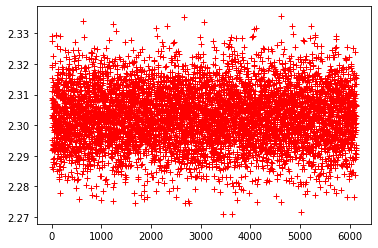

In [16]:
plt.plot(losses, "r+")

In [126]:
np.ma.(losses)

TypeError: 'module' object is not callable

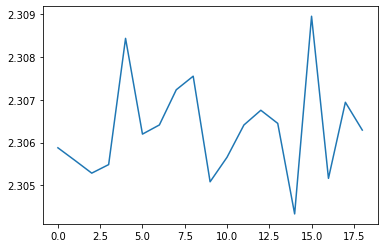

In [134]:
plt.plot(smoothloss(np.array(losses), 5))

In [132]:
def smoothloss(losses, k):
    l = losses
    l = np.reshape(l, (len(l)//k, -1))
    l = np.average(l, 1)
    return l

In [145]:
torch.onnx.export(net, torch.randn(1, 1, 28, 28), 'mnist.onnx', verbose=True)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 6 1 3 3, but got 3-dimensional input of size [1, 28, 28] instead

In [15]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)